<a href="https://colab.research.google.com/github/poojitharajapuram/ML-HW7/blob/main/HW7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6.13 s (started: 2023-12-14 06:43:08 +00:00)


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

time: 16 s (started: 2023-12-14 06:45:52 +00:00)


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

time: 6.63 ms (started: 2023-12-14 06:46:12 +00:00)


In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

time: 689 µs (started: 2023-12-14 06:46:14 +00:00)


In [7]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

100%|██████████| 170498071/170498071 [00:01<00:00, 91239983.31it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
time: 27.3 s (started: 2023-12-14 06:46:20 +00:00)


In [8]:
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

time: 58.3 ms (started: 2023-12-14 06:47:22 +00:00)


In [9]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

time: 899 ms (started: 2023-12-14 06:47:24 +00:00)


In [10]:
cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


time: 422 ms (started: 2023-12-14 06:47:27 +00:00)


In [11]:
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)


time: 1.33 ms (started: 2023-12-14 06:47:31 +00:00)


In [12]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

time: 606 µs (started: 2023-12-14 06:47:34 +00:00)


In [13]:
print(torch.__version__)

2.1.0+cu118
time: 1.54 ms (started: 2023-12-14 06:47:36 +00:00)


In [14]:
import datetime

time: 637 µs (started: 2023-12-14 06:47:38 +00:00)


In [15]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

time: 1.24 ms (started: 2023-12-14 06:47:44 +00:00)


In [16]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

time: 1.25 ms (started: 2023-12-14 06:47:48 +00:00)


In [17]:
import torch.nn.functional as F

time: 500 µs (started: 2023-12-14 06:47:50 +00:00)


In [18]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

time: 963 µs (started: 2023-12-14 06:47:53 +00:00)


In [19]:
device

device(type='cpu')

time: 2.87 ms (started: 2023-12-14 06:47:57 +00:00)


In [ ]:
model = NetResDeep(n_chans1=32, n_blocks=10).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()
training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-13 17:46:36.058580 Epoch 1, Training loss 1.578905702476233
2023-12-13 17:47:07.723692 Epoch 2, Training loss 1.2783425250117473
2023-12-13 17:48:09.521910 Epoch 4, Training loss 1.0689328330415835
2023-12-13 17:49:12.189250 Epoch 6, Training loss 0.9424300517550814
2023-12-13 17:50:14.811090 Epoch 8, Training loss 0.8610171803242872
2023-12-13 17:51:16.793355 Epoch 10, Training loss 0.8023308467117549
2023-12-13 17:52:19.990076 Epoch 12, Training loss 0.7530541792940956
2023-12-13 17:53:23.185688 Epoch 14, Training loss 0.7073105994280683
2023-12-13 17:54:25.187978 Epoch 16, Training loss 0.6712475994307493
2023-12-13 17:55:27.874246 Epoch 18, Training loss 0.635578878190528
2023-12-13 17:56:30.884174 Epoch 20, Training loss 0.5981608909993925
2023-12-13 17:57:33.833626 Epoch 22, Training loss 0.5706200583844481
2023-12-13 17:58:36.828892 Epoch 24, Training loss 0.5407466891716858
2023-12-13 17:59:39.454493 Epoch 26, Training loss 0.513408126148633
2023-12-13 18:00:41.139218 E

In [20]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)
def validate(model, train_loader, val_loader):
    accdict = {}
    predictions = []
    exp_labels = []

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

                predictions.extend(predicted.cpu().numpy())
                exp_labels.extend(labels.cpu().numpy())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict, predictions, exp_labels

time: 2.9 ms (started: 2023-12-14 06:48:15 +00:00)


In [ ]:
accuracy, predictions, expected_labels = validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.67
time: 20.3 s (started: 2023-12-13 20:27:30 +00:00)


In [ ]:
print(classification_report(predictions, expected_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.95      0.95      0.95      6031
  automobile       0.97      0.97      0.97      6010
        bird       0.93      0.93      0.93      5970
         cat       0.91      0.91      0.91      6002
        deer       0.93      0.94      0.94      5973
         dog       0.93      0.92      0.92      6043
        frog       0.96      0.95      0.96      6013
       horse       0.95      0.95      0.95      5985
        ship       0.96      0.96      0.96      6014
       truck       0.96      0.97      0.96      5959

    accuracy                           0.95     60000
   macro avg       0.95      0.95      0.95     60000
weighted avg       0.95      0.95      0.95     60000

time: 140 ms (started: 2023-12-13 20:27:57 +00:00)


In [ ]:
precision = precision_score(predictions, expected_labels, average='macro')
recall = recall_score(predictions, expected_labels, average='macro')
cnf_matrix = confusion_matrix(predictions, expected_labels)

time: 321 ms (started: 2023-12-13 20:28:12 +00:00)


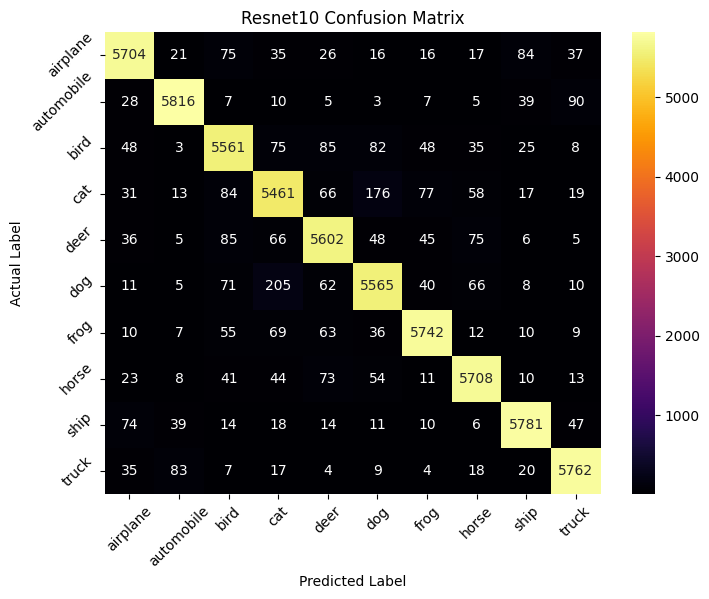

time: 2.05 s (started: 2023-12-13 20:31:05 +00:00)


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, cmap="inferno", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [ ]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

time: 4.93 ms (started: 2023-12-13 20:31:25 +00:00)


In [ ]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

time: 13.2 ms (started: 2023-12-13 20:31:36 +00:00)


In [ ]:
model_wd = NetWidth(n_chans1=32).to(device=device)
optimizer_wd = optim.SGD(model_wd.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()


training_loop_l2reg(
    n_epochs = 300,
    optimizer = optimizer_wd,
    model = model_wd,
    loss_fn = loss_fn,
    train_loader = train_loader,
)


2023-12-13 20:32:06.119388 Epoch 1, Training loss 2.0162307946273432
2023-12-13 20:34:36.580747 Epoch 10, Training loss 1.1714980481835582
2023-12-13 20:37:24.212103 Epoch 20, Training loss 0.9793261258346041
2023-12-13 20:40:13.042034 Epoch 30, Training loss 0.8995208080924685
2023-12-13 20:43:00.117610 Epoch 40, Training loss 0.8567373325757663
2023-12-13 20:45:46.864706 Epoch 50, Training loss 0.8291769826503665
2023-12-13 20:48:34.724966 Epoch 60, Training loss 0.8093630261433399
2023-12-13 20:51:19.725287 Epoch 70, Training loss 0.7944558662984073
2023-12-13 20:54:05.612000 Epoch 80, Training loss 0.7826495583709854
2023-12-13 20:56:54.227372 Epoch 90, Training loss 0.7731172651281137
2023-12-13 20:59:42.505573 Epoch 100, Training loss 0.7652771309818454
2023-12-13 21:02:30.327492 Epoch 110, Training loss 0.7587814625266873
2023-12-13 21:05:16.736032 Epoch 120, Training loss 0.753273863240581
2023-12-13 21:08:01.488309 Epoch 130, Training loss 0.7487081994333535
2023-12-13 21:10:4

In [ ]:
accuracy_wd, predictions_wd, expected_labels_wd = validate(model_wd, train_loader, val_loader)

Accuracy train: 0.86
Accuracy val: 0.70
time: 16.1 s (started: 2023-12-13 21:57:03 +00:00)


In [ ]:
print(classification_report(predictions_wd, expected_labels_wd, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.84      0.86      0.85      5861
  automobile       0.93      0.89      0.91      6252
        bird       0.77      0.76      0.77      6059
         cat       0.76      0.72      0.74      6288
        deer       0.80      0.79      0.79      6088
         dog       0.76      0.82      0.79      5576
        frog       0.87      0.85      0.86      6146
       horse       0.87      0.84      0.86      6201
        ship       0.88      0.92      0.90      5686
       truck       0.88      0.91      0.89      5843

    accuracy                           0.84     60000
   macro avg       0.84      0.84      0.84     60000
weighted avg       0.84      0.84      0.84     60000

time: 299 ms (started: 2023-12-13 21:58:36 +00:00)


In [ ]:
precision_wd = precision_score(predictions_wd, expected_labels_wd, average='macro')
recall_wd = recall_score(predictions_wd, expected_labels_wd, average='macro')
cnf_matrix_wd = confusion_matrix(predictions_wd, expected_labels_wd)

time: 157 ms (started: 2023-12-13 21:58:48 +00:00)


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')])

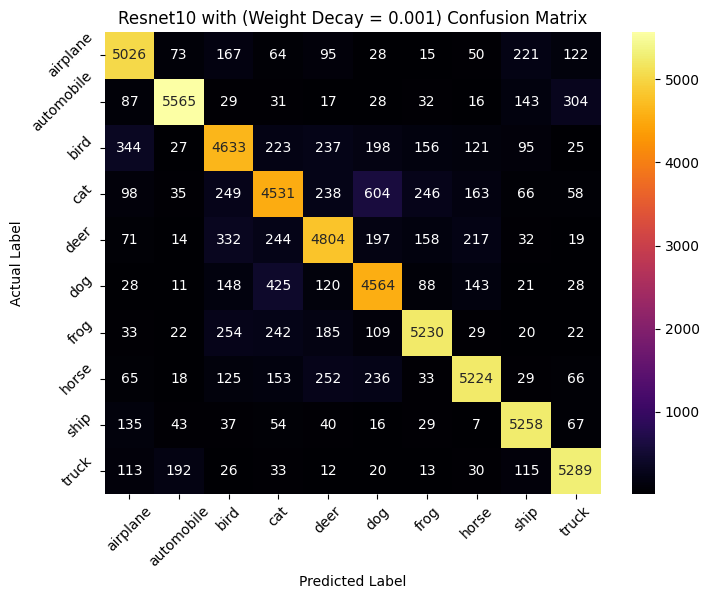

time: 1.22 s (started: 2023-12-13 21:59:13 +00:00)


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_wd, annot=True, cmap="inferno", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 with (Weight Decay = 0.001) Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)


In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.3)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.3)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

time: 2.5 ms (started: 2023-12-13 22:05:07 +00:00)


In [ ]:
model_dropout = NetDropout(n_chans1=32).to(device=device)
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer_dropout,
    model = model_dropout,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-13 22:05:33.951734 Epoch 1, Training loss 2.0109443085272902
2023-12-13 22:05:50.116346 Epoch 2, Training loss 1.777264223836572
2023-12-13 22:06:21.522615 Epoch 4, Training loss 1.5654681542950213
2023-12-13 22:06:52.976146 Epoch 6, Training loss 1.466654319592449
2023-12-13 22:07:24.966379 Epoch 8, Training loss 1.3959889628393265
2023-12-13 22:07:56.504834 Epoch 10, Training loss 1.3385155940299753
2023-12-13 22:08:29.229882 Epoch 12, Training loss 1.2914264144190133
2023-12-13 22:09:00.714061 Epoch 14, Training loss 1.2512863816507638
2023-12-13 22:09:33.086636 Epoch 16, Training loss 1.2196604228385575
2023-12-13 22:10:06.140677 Epoch 18, Training loss 1.1944597309355236
2023-12-13 22:10:38.209225 Epoch 20, Training loss 1.1736547270089464
2023-12-13 22:11:09.992476 Epoch 22, Training loss 1.1553004855085212
2023-12-13 22:11:42.183049 Epoch 24, Training loss 1.1342519001887583
2023-12-13 22:12:13.679938 Epoch 26, Training loss 1.1257548044099832
2023-12-13 22:12:45.794926 

In [ ]:
accuracy_dropout, predictions_dropout, expected_labels_dropout = validate(model_dropout, train_loader, val_loader)

Accuracy train: 0.70
Accuracy val: 0.62
time: 17.1 s (started: 2023-12-13 23:31:16 +00:00)


In [ ]:
print(classification_report(predictions_dropout, expected_labels_dropout, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.74      0.73      0.73      6084
  automobile       0.79      0.80      0.80      5935
        bird       0.54      0.61      0.57      5350
         cat       0.48      0.54      0.51      5426
        deer       0.65      0.60      0.62      6566
         dog       0.57      0.59      0.58      5779
        frog       0.74      0.72      0.73      6230
       horse       0.75      0.71      0.73      6284
        ship       0.82      0.77      0.79      6348
       truck       0.76      0.76      0.76      5998

    accuracy                           0.68     60000
   macro avg       0.68      0.68      0.68     60000
weighted avg       0.69      0.68      0.69     60000

time: 255 ms (started: 2023-12-13 23:31:43 +00:00)


In [ ]:
precision_dropout = precision_score(predictions_dropout, expected_labels_dropout, average='macro')
recall_dropout = recall_score(predictions_dropout, expected_labels_dropout, average='macro')
cnf_matrix_dropout = confusion_matrix(predictions_dropout, expected_labels_dropout)

time: 256 ms (started: 2023-12-13 23:32:50 +00:00)


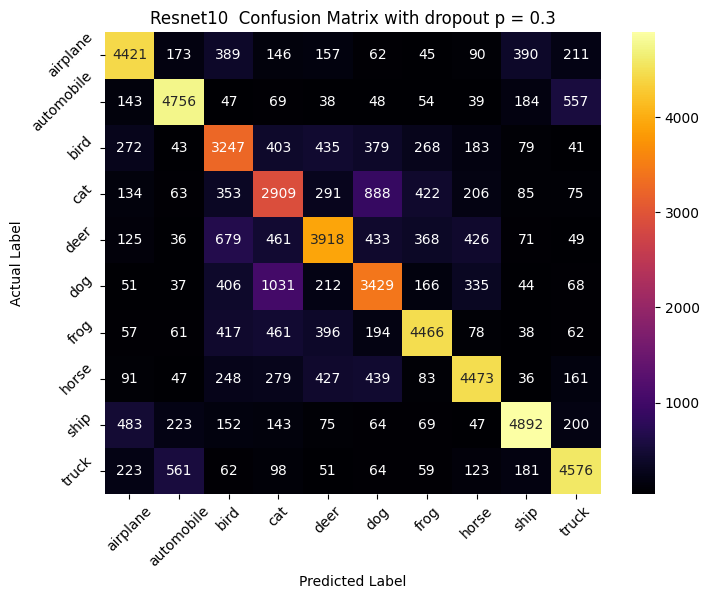

time: 1.03 s (started: 2023-12-13 23:33:26 +00:00)


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_dropout, annot=True, cmap="inferno", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10  Confusion Matrix with dropout p = 0.3')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [25]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

time: 1.03 ms (started: 2023-12-14 06:51:39 +00:00)


In [26]:
model_batch_normal = NetBatchNorm(n_chans1=32).to(device=device)
optimizer_batch_normal = optim.SGD(model_batch_normal.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer_batch_normal,
    model = model_batch_normal,
    loss_fn = loss_fn,
    train_loader = train_loader,
)


2023-12-14 06:52:59.613327 Epoch 1, Training loss 1.7700883554070808
2023-12-14 06:54:14.195883 Epoch 2, Training loss 1.4489441026202248
2023-12-14 06:56:44.352379 Epoch 4, Training loss 1.2120081794536328
2023-12-14 06:59:13.055236 Epoch 6, Training loss 1.0902455783713505
2023-12-14 07:01:42.390557 Epoch 8, Training loss 1.0125111480198248
2023-12-14 07:04:11.073218 Epoch 10, Training loss 0.952991648098392
2023-12-14 07:06:41.352767 Epoch 12, Training loss 0.9066307416657353
2023-12-14 07:09:11.586934 Epoch 14, Training loss 0.8692137912258773
2023-12-14 07:11:40.268670 Epoch 16, Training loss 0.8381012844688752
2023-12-14 07:14:08.680927 Epoch 18, Training loss 0.8109449379127044
2023-12-14 07:16:38.082988 Epoch 20, Training loss 0.7870119091342477
2023-12-14 07:19:06.543869 Epoch 22, Training loss 0.765473645247157
2023-12-14 07:21:35.019536 Epoch 24, Training loss 0.7456748363993052
2023-12-14 07:24:03.631339 Epoch 26, Training loss 0.727384657620469
2023-12-14 07:26:33.761570 E

In [27]:
accuracy_batch_norm, predictions_batch_norm, expected_labels_batch_norm = validate(model_batch_normal, train_loader, val_loader)

Accuracy train: 0.90
Accuracy val: 0.61
time: 1min 26s (started: 2023-12-14 13:12:08 +00:00)


In [30]:
print(classification_report(predictions_batch_norm, expected_labels_batch_norm, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.85      0.86      0.85      5901
  automobile       0.90      0.91      0.91      5901
        bird       0.80      0.79      0.80      6043
         cat       0.77      0.77      0.77      6000
        deer       0.83      0.82      0.82      6019
         dog       0.81      0.80      0.81      6103
        frog       0.88      0.88      0.88      6050
       horse       0.86      0.88      0.87      5891
        ship       0.91      0.89      0.90      6118
       truck       0.89      0.90      0.89      5974

    accuracy                           0.85     60000
   macro avg       0.85      0.85      0.85     60000
weighted avg       0.85      0.85      0.85     60000

time: 190 ms (started: 2023-12-14 13:14:07 +00:00)


In [31]:
precision_batch_norm = precision_score(predictions_batch_norm, expected_labels_batch_norm, average='macro')
recall_batch_norm = recall_score(predictions_batch_norm, expected_labels_batch_norm, average='macro')
cnf_matrix_batch_norm = confusion_matrix(predictions_batch_norm, expected_labels_batch_norm)

time: 195 ms (started: 2023-12-14 13:14:15 +00:00)


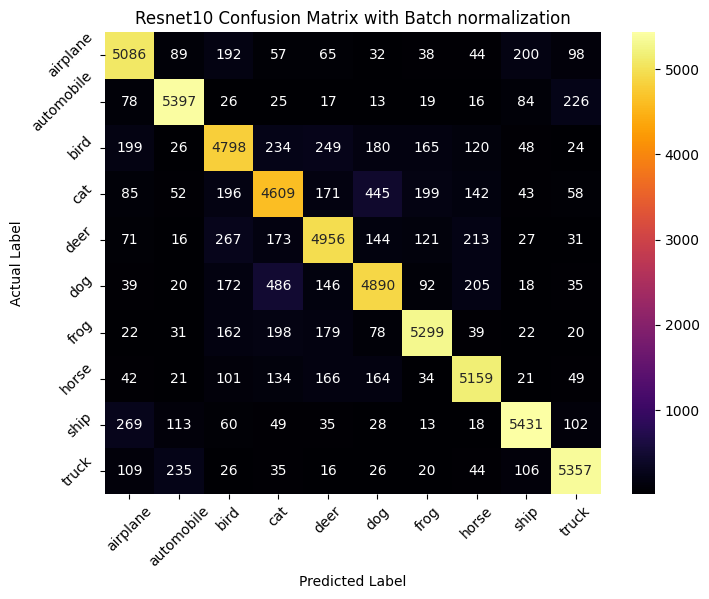

time: 1.3 s (started: 2023-12-14 13:14:36 +00:00)


In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_batch_norm, annot=True, cmap="inferno", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 Confusion Matrix with Batch normalization')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()